# To do:
Groupby skin and look at sentiment outliers
Make sure non-humans are represented
For gender, score unknown and non-human separately

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import sys, os
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
sys.path.append(os.path.join(os.path.curdir, '..', 'sentiment_sports'))
import sports_sentiment as ss

### Load sentiment analyzer

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
stat_words = ['kills']
neutral_words = []
bad_words = ['uninstall']
great_words = []
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

C:\Users\map22\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Create words for known token NER
Load a list of all skins

In [4]:
skin_df = pd.read_csv('modeling_data/labeled_skin_covariates.tsv', sep='\t')
SKIN_SET = set(skin_df['skin_name'].tolist())
SKIN_SET = SKIN_SET | set(skin.lower() for skin in SKIN_SET)
SKIN_SET = set(word.replace('the ', '') for word in SKIN_SET)
SKIN_SET = SKIN_SET | set(skin.replace('.', '') for skin in SKIN_SET )
UPPER_ENTITIES = {'A.I.M', 'Powder', 'Focus', 'Dream', 'Rush', 'Aim',
                  'Guild', 'Grind', 'Ruin', 'Spike', 'Clutch', 'Bullseye',
                 'Fate', 'Oblivion', 'Splode', 'Scout', 'Rebel'}
MIXED_ENTITIES = set(skin.capitalize() for skin in SKIN_SET if len(skin.split()) > 1)
SKIN_SET = SKIN_SET -  {name.lower() for name in UPPER_ENTITIES} | UPPER_ENTITIES | MIXED_ENTITIES

Add streamers and game modes ("Blitz) to non skins set

In [15]:
NON_SKINS_SET = {'ninja', 'tfue', 'epic', 'bugha', 'reverse3k',
             'daequen', 'sypherpk', 'nickmercs', 'hamlinz', 'nickeh30',
             'Horde Rush', 'Aim assist', 'Storm tracker', 'Fortnite tracker', 'Blitz', 'blitz'}
NAMED_ENTITIES = SKIN_SET | NON_SKINS_SET
start_filter =  '^(' +  '|'.join( UPPER_ENTITIES) +')' # this may be too strict; I don't think Rush or Grind have this problem

## Load some data

In [6]:
months_2019 = [f'2019{month:02}' for month in range(1,8)]
months_2018 = [f'2018{month:02}' for month in range(9,13)]
months_overall = months_2018 + months_2019

In [25]:
stub_loc = 'd:/data/fortnite/{}-fortnitebr-comments_submissions.tsv'
zipped_results = [ss.extract_skins_fortnite(stub_loc.format(month), NAMED_ENTITIES, NON_SKINS_SET, sid.polarity_scores) for month in months_overall]
all_extracted_df, all_single_df = zip(*zipped_results)

Loading file: d:/data/fortnite/201809-fortnitebr-comments_submissions.tsv
Chunking into sentences
Reshaping and fixing whitespace / punctuation
Chunked into 751364 sentences
Extracting entities using 1,2,3-grams


C:\Users\map22\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loading file: d:/data/fortnite/201810-fortnitebr-comments_submissions.tsv
Chunking into sentences
Reshaping and fixing whitespace / punctuation
Chunked into 813276 sentences
Extracting entities using 1,2,3-grams
Loading file: d:/data/fortnite/201811-fortnitebr-comments_submissions.tsv
Chunking into sentences
Reshaping and fixing whitespace / punctuation
Chunked into 797199 sentences
Extracting entities using 1,2,3-grams
Loading file: d:/data/fortnite/201812-fortnitebr-comments_submissions.tsv
Chunking into sentences
Reshaping and fixing whitespace / punctuation
Chunked into 806170 sentences
Extracting entities using 1,2,3-grams
Loading file: d:/data/fortnite/201901-fortnitebr-comments_submissions.tsv
Chunking into sentences
Reshaping and fixing whitespace / punctuation
Chunked into 776585 sentences
Extracting entities using 1,2,3-grams
Loading file: d:/data/fortnite/201902-fortnitebr-comments_submissions.tsv
Chunking into sentences
Reshaping and fixing whitespace / punctuation
Chunked 

In [28]:
combined_extracted_df = pd.concat(all_extracted_df)
combined_single_df = pd.concat(all_single_df)
combined_single_df['skins_str'] = combined_single_df['extracted_skins'].str[0].str.lower()

In [29]:
combined_single_df['skins_str'].value_counts().head(10)

drift            7351
omega            6670
john wick        6639
skull trooper    5844
fishstick        4434
dire             3682
peely            3293
ragnarok         3268
black knight     3007
marshmello       2960
Name: skins_str, dtype: int64

#### Verify that extraction is working correctly

In [ ]:
combined_single_df.query('skins_str == "mecha team leader"').sample(10)

In [31]:
combined_single_df.to_csv('d:/data/fortnite/comments_with_single_skins.tsv', sep='\t', index=False)

In [33]:
combined_extracted_df.to_pickle('d:/data/fortnite/comments_with_n_skins.pkl')

### Exploration

In [28]:
exploded_df = combined_extracted_df.explode('extracted_skins')
skin_counts_series = exploded_df['extracted_skins'].str.lower().value_counts()
skin_counts_series.head(5)

skull trooper    6648
omega            4036
drift            3060
dire             3025
marshmello       2299
Name: extracted_skins, dtype: int64

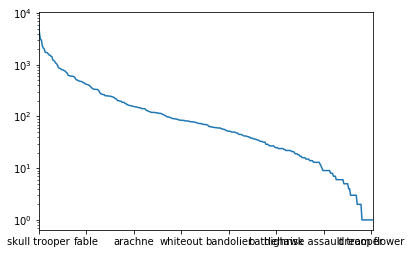

In [32]:
skin_counts_series.plot.line()
plt.yscale('log')

### Regression

In [27]:
skin_df.sample(10)

,skin_name,skin_source,skin_rarity,race,gender,story_skin,skin_set,release_date,release_datetime
188,Ice Queen,2000 V-Bucks,Legendary,W,M,NaN,NaN,NaN,NaN
174,Hime,2000 V-Bucks,Legendary,A,F,NaN,Bushido,23-Aug-18,2018-08-23
221,Masked Fury,1200 V-Bucks,Rare,L,M,NaN,Lucha,07-20-2018,2018-07-20
409,Verge,800 V-Bucks,\r\n,NaN,M,NaN,Modern Mercenary,16-Jan-19,2019-01-16
219,Marked Marauder,800 V-Bucks,\r\n,W,M,NaN,Banner Brigade,17-Jul-19,2019-07-17
15,Assault Trooper,800 V-Bucks,Uncommon,L,F,NaN,NaN,31-Oct-17,2017-10-31
207,Lt. Logo,800 V-Bucks,Uncommon,B,M,NaN,Banner Brigade,17-Jul-19,2019-07-17
370,Sunflower,800 V-Bucks,Uncommon,W,F,NaN,Fatal Fielders,5-Mar-19,2019-03-05
312,Scarlet Defender,800 V-Bucks,Uncommon,L,F,NaN,NaN,25-Feb-18,2018-02-25
349,Spooky Team Leader,1500 V-Bucks,Epic,NaN,F,NaN,NaN,1-Nov-18,2018-11-01


In [34]:
skin_df['skins_str'] = skin_df['skin_name'].str.lower()
join_df = combined_single_df.merge(skin_df, on='skins_str')

In [21]:
#join_df.to_csv('modeling_data/fortnite_sentiment_data.tsv', sep='\t', index=False)
join_df = pd.read_csv('modeling_data/fortnite_sentiment_data.tsv', sep='\t').fillna({'race':'unknown',
                                                                                     'gender':'non-human',
                                                                                     'story_skin':False})

In [23]:
join_df.gender.value_counts()

M            29402
F            14000
non-human        6
Name: gender, dtype: int64

In [24]:
model = smf.wls( formula = 'compound ~ race + gender +skin_rarity + story_skin',
                data = join_df#,
#               weights = 1# / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               compound   R-squared:                       0.064
Model:                            WLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     249.2
Date:                Wed, 28 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:03:33   Log-Likelihood:                -16629.
No. Observations:               43408   AIC:                         3.328e+04
Df Residuals:                   43395   BIC:                         3.340e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1076      0.030      3.628      0.000       0.049       0.166
race[T.B]                    0.0412      0.014      2.976      0.003       0.014       0.068
race[T.L]                   -0.0465      0.014     -3.339      0.001      -0.074      -0.019
race[T.SELECT]               0.0168      0.026      0.642      0.521      -0.035       0.068
race[T.W]                   -0.0555      0.013     -4.256      0.000      -0.081      -0.030
race[T.unknown]             -0.0244      0.013     -1.863      0.062      -0.050       0.001
gender[T.M]                 -0.0468      0.004    -10.504      0.000      -0.056      -0.038
gender[T.non-human]         -0.1036      0.145     -0.714      0.475      -0.388       0.181
skin_rarity[T.Epic]          0.0466      0.027      1.740      0.082      -0.006       0.099
skin_rarity[T.Legendary]     0.0116      0.027      0.434      0.664      -0.041       0.064
skin_rarity[T.Rare]          0.0010      0.027      0.038      0.969      -0.052       0.054
skin_rarity[T.Uncommon]      0.0091      0.028      0.328      0.743      -0.045       0.063
story_skin[T.True]          -0.5032      0.011    -46.409      0.000      -0.524      -0.482
==============================================================================
Omnibus:                       48.404   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.869
Skew:                           0.076   Prob(JB):                     2.45e-11
Kurtosis:                       3.064   Cond. No.                         128.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Old NER code (didn't work due to too many common words and reused words across skins)

In [83]:
%%time
# 1 min if memory constrained
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
ddf = dd.from_pandas(july_sentences_df, npartitions=12)
test_df= ddf.map_partitions(lambda df: ss.extract_known_ner(df, NAMED_ENTITIES, UPPER_ENTITIES)).compute()
client.close()


Wall time: 33.9 s


In [84]:
%%time
#test_df = ss.extract_known_ner(july_sentences_df, NAMED_ENTITIES, UPPER_ENTITIES)
test_df = ss.clean_entities(test_df, non_players_set=NON_SKINS,max_entities = 4)

Outputting 90243 sentences which have 1-2 named entities
Wall time: 5.04 s


In [94]:
test_df['skin_match'] = test_df['str_entities'].apply(lambda row: row in skin_set)
test_df.query('skin_match')['str_entities'].value_counts().head(20)

singularity      1028
drift             720
fishstick         555
grind             438
peely             432
omega             299
beach bomber      287
marshmello        280
ruin              256
breakpoint        243
john wick         232
demogorgon        225
vendetta          197
luxe              183
demi              165
ikonik            159
rust lord         147
hopper            123
rox               118
bunker jonesy     114
Name: str_entities, dtype: int64